In [1]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 2.0MB/s 
     |████████████████████████████████| 3.8MB 40.2MB/s 
     |████████████████████████████████| 450kB 40.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=346c63d710440953f7a35718b86a304ddae01f59185a3457f454c3dd8b207280
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)



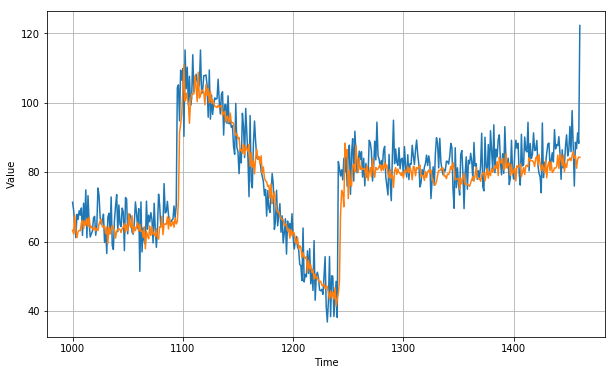

In [6]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1813784

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

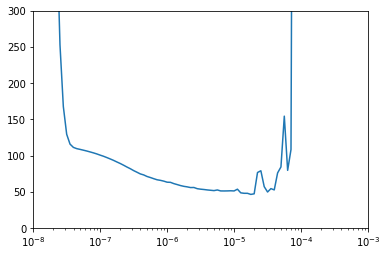

In [9]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

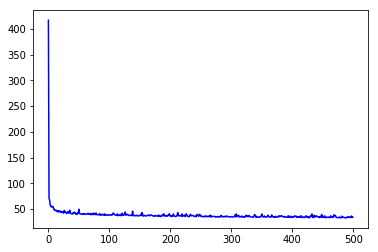

In [11]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[48.90923885856707, 46.888973527102124, 46.72044133451796, 47.665136152444425, 45.168641772712625, 44.70147284281622, 46.49317367396404, 44.15075581344133, 46.69663036385762, 44.96413429496214, 45.07105988964592, 42.946069682013125, 45.41937111923375, 43.59138727089793, 44.411737563929606, 41.64437433616402, 47.23566230695272, 45.107446383446764, 43.564094559187744, 42.35997377375966, 41.058969558637166, 44.222103331261074, 44.78946249263803, 42.08334733628735, 42.328388902329905, 47.509042507840185, 41.499146215694466, 41.29160063438809, 40.96059630089199, 40.10314598870032, 40.9332654500745, 43.375250031776034, 41.952593003105875, 43.822742147544, 42.23942528164264, 39.892833402967945, 39.96481441222515, 39.48380529266043, 42.724559429994564, 41.44744629220864, 49.44555200793079, 42.0995635121139, 40.222885297008396, 40.08249357951056, 40.09112615683644, 40.56364670193072, 40.531359485744204, 39.199530587737094, 40.5565244694346, 40.885079342556985, 39.70208516071752, 39.594770663546

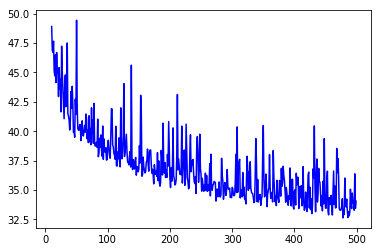

In [12]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

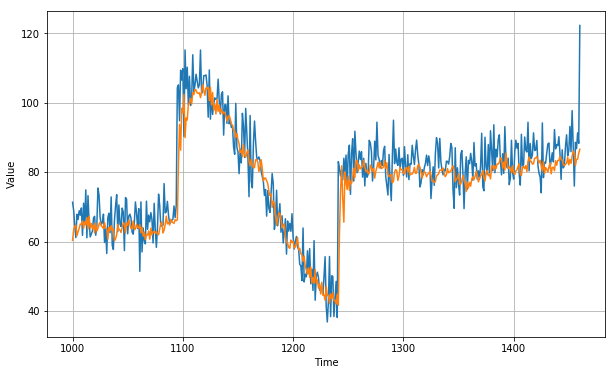

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.119594